# Inter-clade and intra-clade ANI analysis

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Read fastANI results table
colnames = ["Query", "Reference", "ANI", "Bidirectional mappings", "Query fragments"]
df = pd.read_csv('fastANI_final_results.txt', sep = '\t', names = colnames, header = None)

# Formatting names
full_dir = "/home/estudiante2/JMF/final_analysis/SAR11_genomes/"

df["Query"] = df["Query"].str.replace(full_dir, "", regex=False)
df["Query"] = df["Query"].str.replace('.fa', "", regex=False)
df["Reference"] = df["Reference"].str.replace(full_dir, "", regex=False)
df["Reference"] = df["Reference"].str.replace('.fa', "", regex=False)

df.head(10)

,Query,Reference,ANI,Bidirectional mappings,Query fragments
0,AAA240-E13_Ic,AAA240-E13_Ic,100.0000,404,407
1,AAA240-E13_Ic,HIMB1662_Ia.3.VI,76.7311,82,407
2,AAA240-E13_Ic,HIMB1835_Ia.4.II,76.6913,49,407
3,AAA240-E13_Ic,HIMB1602_Ia.3.VI,76.6763,57,407
4,AAA240-E13_Ic,AG-430-B09_nan,76.6076,87,407
5,AAA240-E13_Ic,AG-892-A22_Ia.3.V,76.6064,79,407
6,AAA240-E13_Ic,AG-410-L19_nan,76.5888,70,407
7,AAA240-E13_Ic,AG-390-L03_Ia.3.IV,76.5373,82,407
8,AAA240-E13_Ic,HIMB1695_Ia.3.VI,76.5244,86,407
9,AAA240-E13_Ic,FZCC0015_Ia.3.V,76.5036,96,407


### Clean the dataset

In [4]:
# Create clade column
df["clade1"] = df["Query"].str.split('_', expand=True)[1]
df["clade2"] = df["Reference"].str.split('_', expand = True)[1]

In [5]:
# Drop duplicates
ani = df[df["Query"] != df["Reference"]]

In [6]:
# Drop simetrics (A-B and B-A)
ani["pair"] = ani.apply(
    lambda r: "___".join(sorted([r["Query"], r["Reference"]])),
    axis=1
)

ani = ani.drop_duplicates("pair")

C:\Users\JorgeXD\AppData\Local\Temp\ipykernel_8464\1255571766.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ani["pair"] = ani.apply(


### Intra-clade mean ANI

In [8]:
intra = ani[ani["clade1"] == ani["clade2"]]

# Compute mean intra-clade ANI
mean_ani_intra = (
    intra
    .groupby("clade1")["ANI"]
    .mean()
    .reset_index()
    .rename(columns={"clade1": "clade", "ANI": "mean_ANI"})
)

In [9]:
mean_ani_intra.head()

,clade,mean_ANI
0,II,80.154378
1,III,83.666688
2,Ia.1.I,91.061783
3,Ia.3.I,92.193900
4,Ia.3.II,89.514213


### Inter-clade mean ANI

In [10]:
# Compute inter-clade mean
inter = ani[ani["clade1"] != ani["clade2"]]

mean_ani_inter = (
    inter
    .groupby(["clade1", "clade2"])["ANI"]
    .mean()
    .reset_index()
)

In [11]:
mean_ani_inter.head(10)

,clade1,clade2,ANI
0,II,Ia.1.I,76.713329
1,II,Ia.3.I,76.647612
2,II,Ia.3.II,76.816958
3,II,Ia.3.III,76.707476
4,II,Ia.3.IV,76.620950
5,II,Ia.3.V,76.580010
6,II,Ia.3.VI,76.642073
7,II,Ia.3.VII,76.667123
8,II,Ia.4.II,76.769963
9,II,Ia.4.N1,76.702119


In [12]:
print('Intra-clade range:')
print(max(mean_ani_intra["mean_ANI"].tolist()))
print(min(mean_ani_intra["mean_ANI"].tolist()))

print('\nInter-clade range:')
print(max(mean_ani_inter["ANI"].tolist()))
print(min(mean_ani_inter["ANI"].tolist()))


Intra-clade range:
95.40500000000002
79.38968260869565

Inter-clade range:
86.04444
75.6047


## Representation

In [17]:
intra_pairs = mean_ani_intra.rename(columns={"clade": "clade1", "mean_ANI": "ANI"})
intra_pairs["clade2"] = intra_pairs["clade1"]

In [22]:
mean_ani_combined.tail()

,clade1,clade2,ANI
630,Ib.4.N8,Ib.4.N8,89.635180
631,Ib.4.N9,Ib.4.N9,91.700933
632,Ib.N10,Ib.N10,95.405000
633,Ib.N11,Ib.N11,89.855667
634,nan,nan,79.389683


In [23]:
# Transform into matrix
ani_mat = mean_ani_combined.pivot(
    index="clade1",
    columns="clade2",
    values="ANI"
)

In [24]:
# Symetrix matrix
ani_mat = ani_mat.combine_first(ani_mat.T)
ani_mat

,II,III,Ia.1.I,Ia.3.I,Ia.3.II,Ia.3.III,Ia.3.IV,Ia.3.V,Ia.3.VI,Ia.3.VII,...,Ib.1.III,Ib.2.I,Ib.2.N7,Ib.4.1,Ib.4.N8,Ib.4.N9,Ib.N10,Ib.N11,Ic,nan
clade1,,,,,,,,,,,,,,,,,,,,,
II,80.154378,NaN,76.713329,76.647612,76.816958,76.707476,76.620950,76.580010,76.642073,76.667123,...,76.539842,76.614100,76.470850,76.516880,76.366725,76.606200,76.586633,76.483600,76.744600,76.597169
III,NaN,83.666688,NaN,NaN,NaN,NaN,NaN,75.850100,75.604700,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Ia.1.I,76.609517,NaN,91.061783,79.357033,78.645488,78.597700,79.674333,78.750755,78.937414,78.579150,...,77.557245,77.525910,77.399840,77.124475,77.167825,77.266269,77.546242,77.209933,76.290800,78.262683
Ia.3.I,76.598438,NaN,79.009100,92.193900,78.867783,79.363425,82.424550,80.549556,80.359711,80.405306,...,77.509855,77.812000,77.563325,77.427550,77.288700,77.396933,77.050533,77.166350,76.255900,78.694554
Ia.3.II,76.493254,NaN,78.645488,79.059267,89.514213,79.544600,79.051033,79.045047,79.590217,78.749800,...,77.886493,77.650823,77.738310,77.470350,77.594093,77.487829,77.449394,77.491006,76.338300,78.643870
Ia.3.III,76.485125,NaN,78.597700,79.547775,79.550369,95.375967,79.370075,79.428167,79.890284,79.196350,...,77.712346,77.586530,77.632675,77.524225,77.509670,77.425250,77.500592,77.285092,76.205500,78.770306
Ia.3.IV,76.613717,NaN,79.478980,82.774800,78.957417,79.612475,87.235500,81.181843,80.744624,80.412705,...,78.188265,78.214675,77.691060,77.553500,77.472980,77.522200,77.567400,77.496450,76.537300,78.852704
Ia.3.V,76.600559,75.850100,78.750755,80.887193,79.071911,79.446804,80.773678,90.273826,82.042279,80.919151,...,78.131117,77.982472,77.944280,77.379360,77.616994,77.499017,77.342186,77.618667,76.388767,78.939645
Ia.3.VI,76.505048,76.051333,78.937414,80.486796,79.595743,79.776405,80.690204,82.292614,94.592224,80.486803,...,78.037815,78.232650,77.971520,77.974500,77.481360,77.431875,77.409433,77.641050,76.464444,78.838581


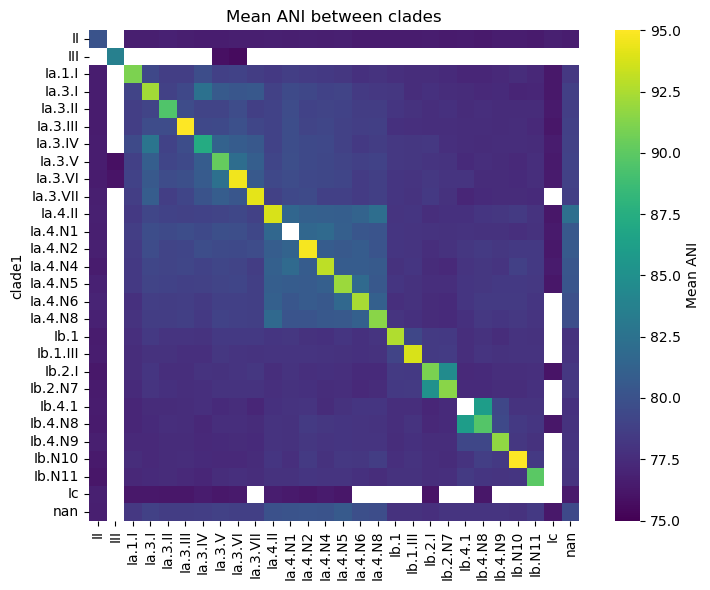

In [27]:
# First heatmap view
plt.figure(figsize=(8, 6))
sns.heatmap(
    ani_mat,
    cmap="viridis",
    vmin=75,
    vmax=95,
    square=True,
    cbar_kws={"label": "Mean ANI"}
)
plt.title("Mean ANI between clades")
plt.tight_layout()
plt.show()

In [28]:
# Save figure
plt.figure(figsize=(8, 6))
sns.heatmap(
    ani_mat,
    cmap="rocket_r",
    vmin=75,
    vmax=95,
    linewidths=0.5,
    linecolor="white",
    cbar_kws={"label": "Mean ANI (%)"}
)
plt.xlabel("")
plt.ylabel("")
plt.title("Average pairwise ANI between clades")
plt.tight_layout()
plt.savefig("ANI_clade_heatmap.png", dpi=300)
plt.close()

### Compute clade grouping by ANI

In [29]:
ANI_th = 90

sset = mean_ani_combined[mean_ani_combined["ANI"] >= ANI_th]

In [32]:
sset

,clade1,clade2,ANI
612,Ia.1.I,Ia.1.I,91.061783
613,Ia.3.I,Ia.3.I,92.193900
615,Ia.3.III,Ia.3.III,95.375967
617,Ia.3.V,Ia.3.V,90.273826
618,Ia.3.VI,Ia.3.VI,94.592224
619,Ia.3.VII,Ia.3.VII,94.193852
620,Ia.4.II,Ia.4.II,93.782364
621,Ia.4.N2,Ia.4.N2,94.700300
622,Ia.4.N4,Ia.4.N4,93.014900
623,Ia.4.N5,Ia.4.N5,91.977700


No ANI > 90 is shared between genomes of different clades

### Histogram showing ANI distribution accross genomic pairs

In [9]:
ani.shape

(29165, 8)

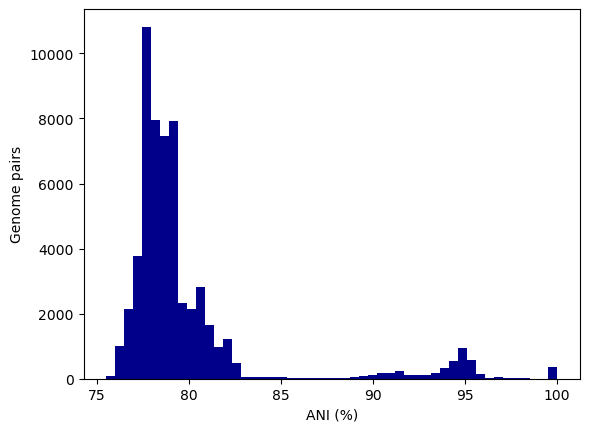

In [18]:
plt.figure()
plt.hist(df["ANI"], bins=50, color='darkblue')
plt.xlabel("ANI (%)")
plt.ylabel("Genome pairs")
plt.savefig('Pairwise_ANI_dist', dpi = 300)
plt.show()

In [20]:
sset = ani[(ani["ANI"] > 83) & (ani["ANI"] < 90)]

In [28]:
perc = sset.shape[0] / ani.shape[0] * 100
print(round(perc, 2), '%')

1.0 %


Only $1\%$ of the pairwise comparisons belong to the interval $83\%$ - $90\%$ ANI